This notebook is used to run the default process-based JAX-CanVeg in US-Bi1 site.

# Load the necessary libraries

In [1]:
# # TODO: A more generic way is needed here to load the path
# import sys

# sys.path.append(
#     "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
#     # "/global/homes/p/peishi89/jax-watershed/src"
# )

In [1]:
import optax
import equinox as eqx

import pickle
from functools import partial

from math import floor

# import numpy as np
import jax
import jax.numpy as jnp
import jax.tree_util as jtu

import pandas as pd

from jax_canveg.physics.energy_fluxes import get_dispersion_matrix

from jax_canveg.models import CanvegIFT
from jax_canveg.models import get_canle, update_canle
from jax_canveg.models import get_soilresp, update_soilresp
from jax_canveg.models import load_model, save_model

# from jax_canveg.shared_utilities.optim import perform_optimization
from jax_canveg.shared_utilities.optim import perform_optimization_batch
from jax_canveg.shared_utilities import compute_metrics
from jax_canveg.subjects import convert_met_to_batched_met
from jax_canveg.subjects import (
    # convert_batchedstates_to_states,
    convert_obs_to_batched_obs,
)
from jax_canveg.subjects import get_met_forcings, get_obs, initialize_parameters
from jax_canveg.models import run_canveg_in_batch

from jax_canveg.models import save_model

import matplotlib.pyplot as plt
from jax_canveg.shared_utilities.plot import (
    plot_daily,
    plot_imshow2,
    plot_timeseries_obs_1to1,
    plot_rad,
    plot_ir,
    visualize_tree_diff,
)
from jax_canveg.shared_utilities.plot import (
    plot_obs_1to1,
    plot_obs_comparison,
    plot_obs_energy_closure,
    plot_dij,
    plot_para_sensitivity_ranking,
    plot_le_gs_lai,
    get_time,
)

# from jax_canveg.shared_utilities.plot import plot_veg_temp, plot_dij
# from jax_canveg.shared_utilities.plot import plot_ir, plot_rad, plot_prof2
from jax_canveg.shared_utilities import tune_jax_naninfs_for_debug

jax.config.update("jax_enable_x64", True)
tune_jax_naninfs_for_debug(False)
# jax.config.update("jax_debug_nans", False)
# jax.config.update("jax_debug_infs", False)
# jax.config.update("XLA_PYTHON_CLIENT_ALLOCATOR", 'platform')

%load_ext autoreload
%autoreload 2

# Model parameters and settings

In [2]:
time_zone = -8
latitude = 46.4089
longitude = -119.2750
stomata = 0
veg_ht = 1.2
# leafangle = 2  # erectophile
leafangle = 1
n_can_layers = 50
n_atmos_layers = 50
meas_ht = 5.0
soil_depth = 0.15
n_hr_per_day = 48
niter = 15
# niter = 1

# batch_size = 2
# batch_size = 1274
# batch_size = int(74496/2)
batch_size, batch_size_test = None, None

site = "US-Hn1"
key = "default"

# Calibration period
f_forcing = f"../../data/fluxtower/{site}/{site}-forcings-v2.csv"
f_obs = f"../../data/fluxtower/{site}/{site}-fluxes-nonegle-v2.csv"

# Test period
f_forcing_test = f"../../data/fluxtower/{site}/{site}-forcings-test-v2.csv"
f_obs_test = f"../../data/fluxtower/{site}/{site}-fluxes-nonegle-test-v2.csv"

# Models
f_model = f"{site}_{key}_model.eqx"
# f_model_new = f"{site}_{key}_model.eqx"

# Load and set the model forcings

In [3]:
# Training
met, n_time = get_met_forcings(f_forcing)
if batch_size is None:
    batch_size = n_time
n_batch = floor(n_time / batch_size)
batched_met = convert_met_to_batched_met(met, n_batch, batch_size)
timesteps = get_time(met)

In [4]:
# Test
met_test, n_time_test = get_met_forcings(f_forcing_test)
if batch_size_test is None:
    batch_size_test = n_time_test
n_batch_test = floor(n_time_test / batch_size_test)
batched_met_test = convert_met_to_batched_met(met_test, n_batch_test, batch_size_test)
timesteps_test = get_time(met_test)

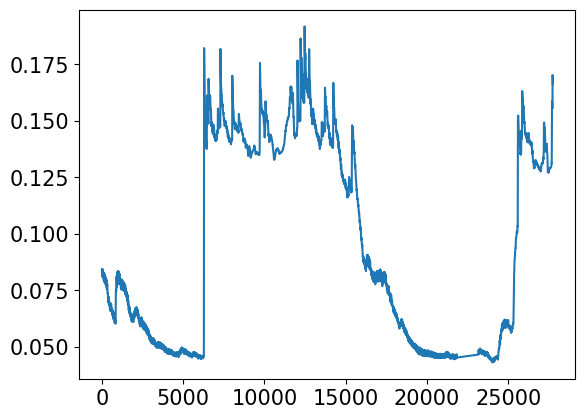

In [5]:
plt.plot(met.soilmoisture)

# Load the observations

In [6]:
# Training
obs = get_obs(f_obs)

# Test
obs_test = get_obs(f_obs_test)

/global/homes/p/peishi89/jax-watershed/src/jax_canoak/subjects/initialization_update.py:270: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both", inplace=True)
/global/homes/p/peishi89/jax-watershed/src/jax_canoak/subjects/initialization_update.py:270: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both", inplace=True)


# Create the model parameter instance

In [7]:
setup, para, para_min, para_max = initialize_parameters(
    time_zone=time_zone,
    latitude=latitude,
    longitude=longitude,
    stomata=stomata,
    veg_ht=veg_ht,
    leafangle=leafangle,
    n_can_layers=n_can_layers,
    n_atmos_layers=n_atmos_layers,
    meas_ht=meas_ht,
    soil_depth=soil_depth,
    n_hr_per_day=n_hr_per_day,
    n_time=n_time,
    npart=int(1e6),
    obs=obs,
    met=met,
    niter=niter,
    get_para_bounds=True,
)

# Generate or read the dispersion matrix

In [8]:
# dij = get_dispersion_matrix(setup, para)
dij = get_dispersion_matrix(setup, para, f"../../data/dij/Dij_{site}.csv")
# import numpy as np
# np.savetxt(f"../../data/dij/Dij_{site}.csv", np.array(dij), delimiter=',')

<Axes: xlabel='Dij [s/m]', ylabel='Height [m]'>

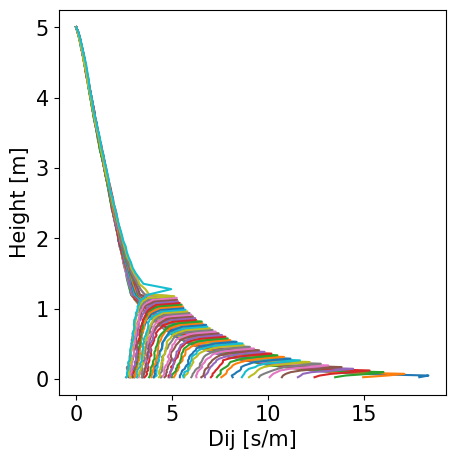

In [9]:
plot_dij(dij, para)

# Run CanVeg!

In [10]:
jax.clear_caches()
canveg_eqx_ift = CanvegIFT(para, setup, dij)

In [11]:
# Training data
# met, prof, ir, qin, sun, shade, soil, veg, can = canveg_eqx_ift(met)
states, drivers = canveg_eqx_ift(met)
met, prof, ir, qin, sun, shade, soil, veg, can = states
quantum, nir, rnet, sun_ang, leaf_ang, lai = drivers
# met, prof, ir, qin, sun, shade, soil, veg, can = run_canveg_in_batch(batched_met, canveg_eqx_ift)

In [12]:
# Test data
states_test, drivers_test = canveg_eqx_ift(met_test)
(
    met_test,
    prof_test,
    ir_test,
    qin_test,
    sun_test,
    shade_test,
    soil_test,
    veg_test,
    can_test,
) = states_test
quantum_test, nir_test, rnet_test, sun_ang_test, leaf_ang_test, lai_test = drivers_test

/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:120: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:120: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


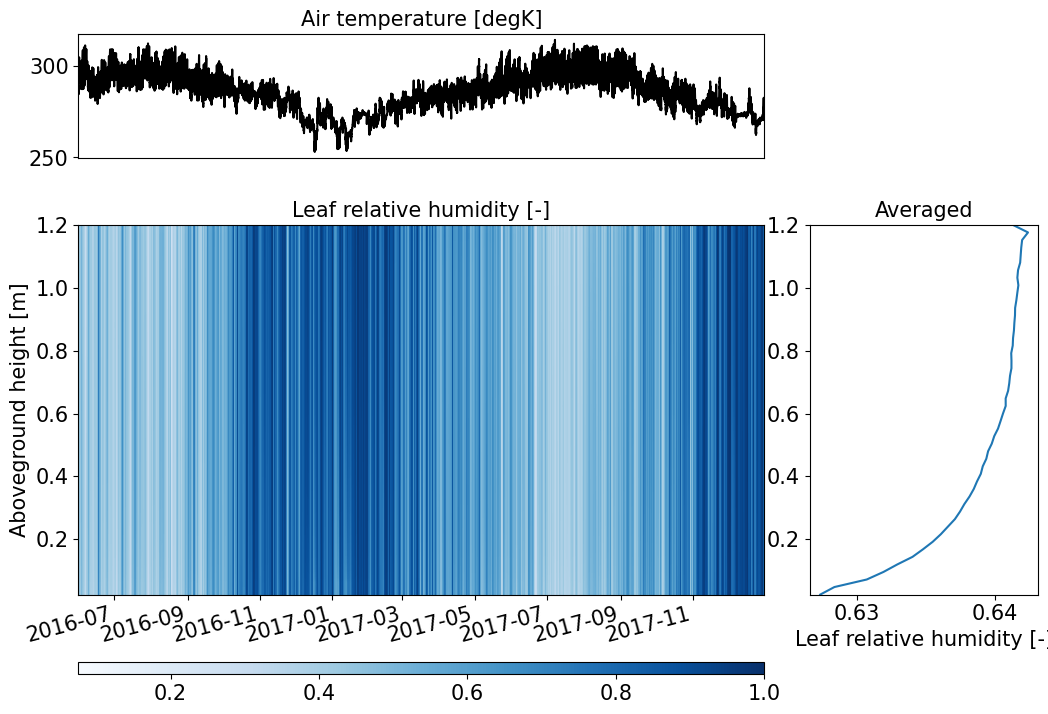

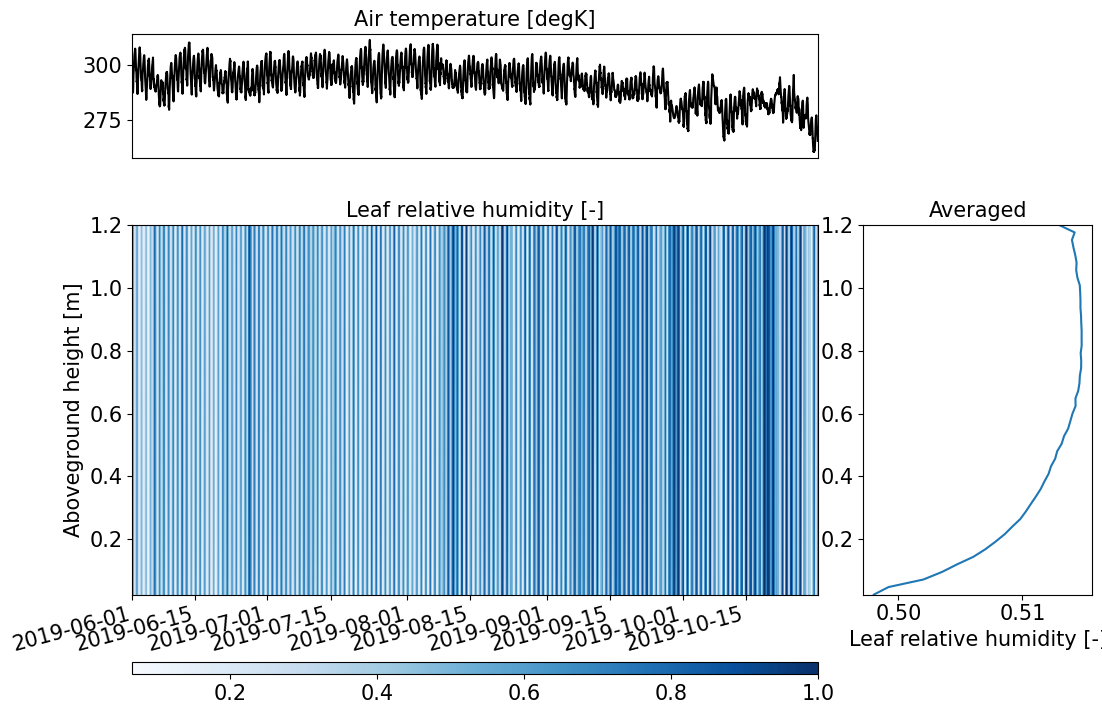

In [13]:
# Leaf relative humidity
plot_imshow2(
    sun.Leaf_RH.T,
    met,
    para.zht1,
    key="T",
    title="Leaf relative humidity [-]",
    cmap="Blues",
)

plot_imshow2(
    sun_test.Leaf_RH.T,
    met_test,
    para.zht1,
    key="T",
    title="Leaf relative humidity [-]",
    cmap="Blues",
)

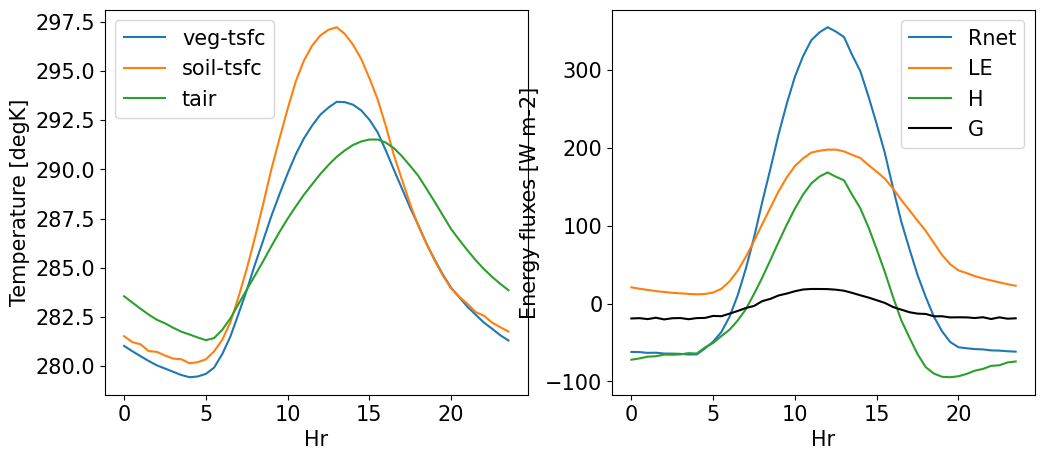

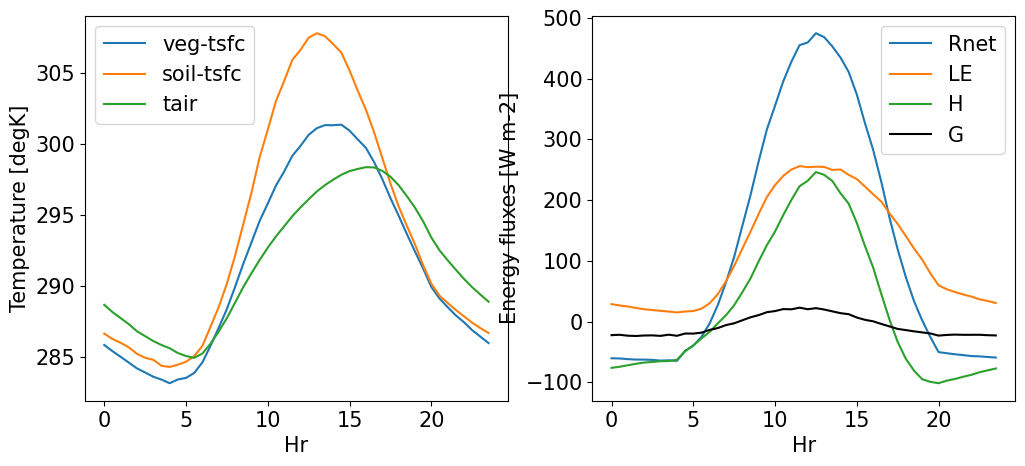

In [14]:
# Daily average
plot_daily(met, soil, veg, para)
plot_daily(met_test, soil_test, veg_test, para);

In [27]:
# Analyze nan
nanind = jnp.where(jnp.isnan(prof.Tair_K.mean(axis=1)))

met.lai[nanind]
# qin.sun_abs[nanind]
# ir.ir_in[nanind]
sun.Tsfc[nanind, :]

Array([], dtype=float64)

# Local sensitivity analysis

In [52]:
jax.clear_caches()


@eqx.filter_jit
@partial(jax.grad, argnums=0)
def df_canveg_le(para, met, canveg_eqx):
    canveg_eqx = eqx.tree_at(lambda t: t.para, canveg_eqx, para)
    can_le = canveg_eqx.get_fixed_point_states(met, update_canle, get_canle)
    # met, update_soilresp, get_soilresp)
    return can_le.sum()


@eqx.filter_jit
def df_canveg_le_batched(para, batched_met, canveg_eqx):
    def compute_grad(para, met):
        grad = df_canveg_le(para, met, canveg_eqx)
        return para, grad

    _, gradients = jax.lax.scan(compute_grad, para, xs=batched_met)
    return gradients


# eqx.filter_make_jaxpr(df_canveg_le3)(para, met, canveg_eqx)

## Perform SA at one time step

In [53]:
start, ntime = 20, 1
met2 = jtu.tree_map(lambda x: x[start : start + ntime], met)

In [54]:
gradients = df_canveg_le(para, met2, canveg_eqx_ift)

In [55]:
gradients.lleaf

Array(-20.70639241, dtype=float64, weak_type=True)

## Perform SA at multiple steps

In [56]:
jax.clear_caches()
batched_met_sa = convert_met_to_batched_met(met, n_time, 1)
gradients = df_canveg_le_batched(para, batched_met_sa, canveg_eqx_ift)

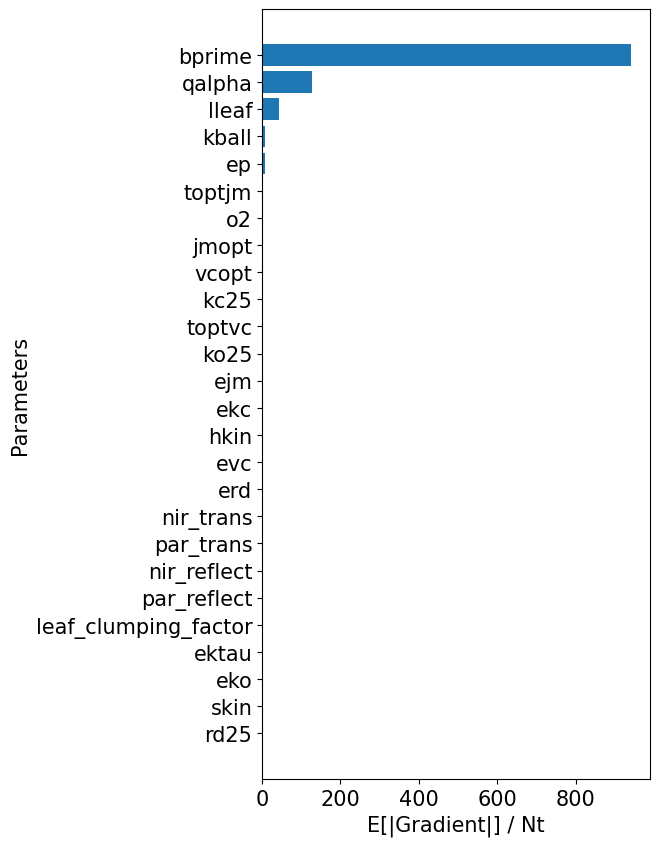

In [57]:
plot_para_sensitivity_ranking(gradients, category="photosyn")
# plot_para_sensitivity_ranking(gradients, category=None)

In [40]:
# gm = jtu.tree_map(lambda x:x.mean(), gradients)
# a, b = jtu.tree_flatten(gm)

In [75]:
# bb = b.node_data()[1]
# names = bb.dynamic_field_names

# Comparison with the observations

<Axes: xlabel='Rnet, measured', ylabel='H+LE+Gsoil, measured'>

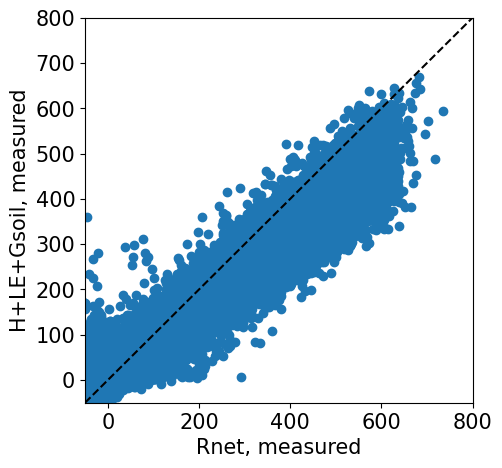

In [15]:
plot_obs_energy_closure(obs)

<Axes: title={'center': 'Rnet (L2: 1528.072)'}, xlabel='Observation', ylabel='JAX-CANOAK'>

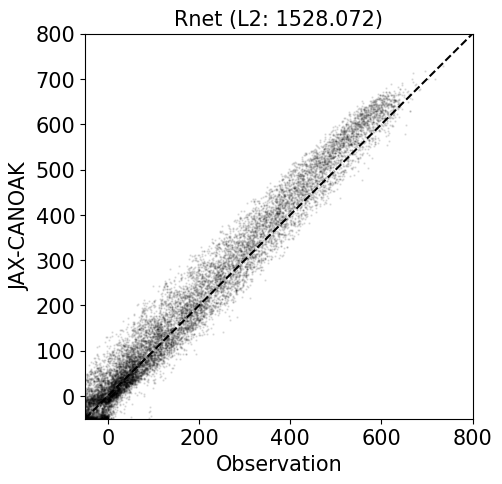

In [16]:
plot_obs_1to1(obs.rnet, can.rnet, lim=[-50, 800], varn="Rnet")

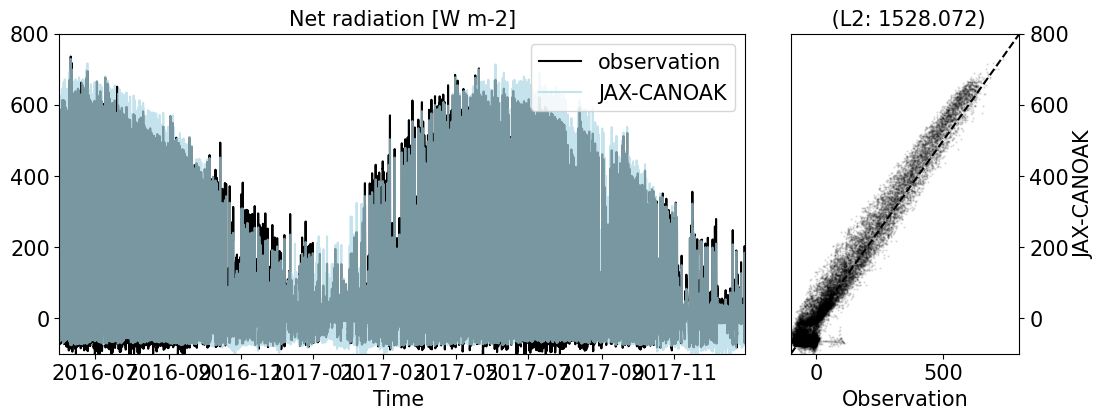

In [17]:
plot_timeseries_obs_1to1(
    obs.rnet,
    can.rnet,
    lim=[-100, 800],
    met=met,
    varn="Net radiation [W m-2]",
);

In [40]:
# plt.figure(0)
# plt.plot(obs.P)
# plt.figure(1)
# plt.plot(obs.Rsoil)
# plt.figure(1)
# plt.plot(soil.resp)

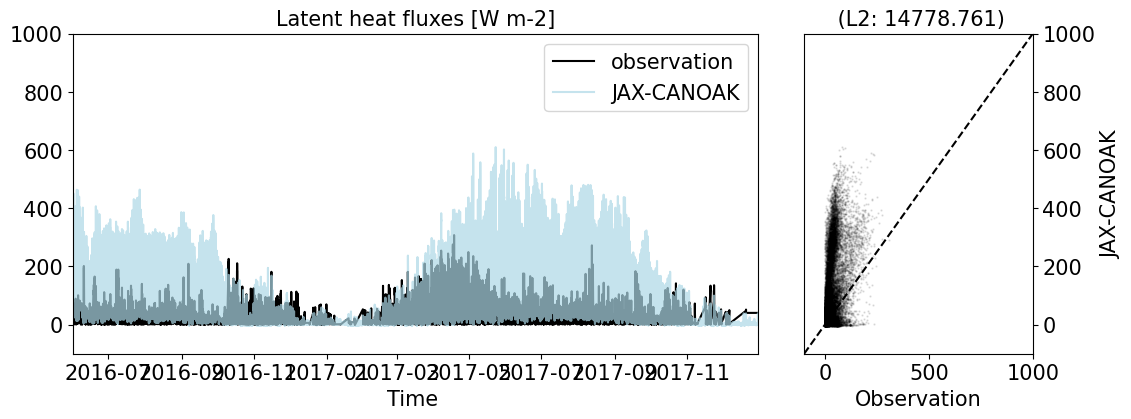

In [18]:
plot_timeseries_obs_1to1(
    obs.LE,
    can.LE,
    lim=[-100, 1000],
    met=met,
    varn="Latent heat fluxes [W m-2]",
);

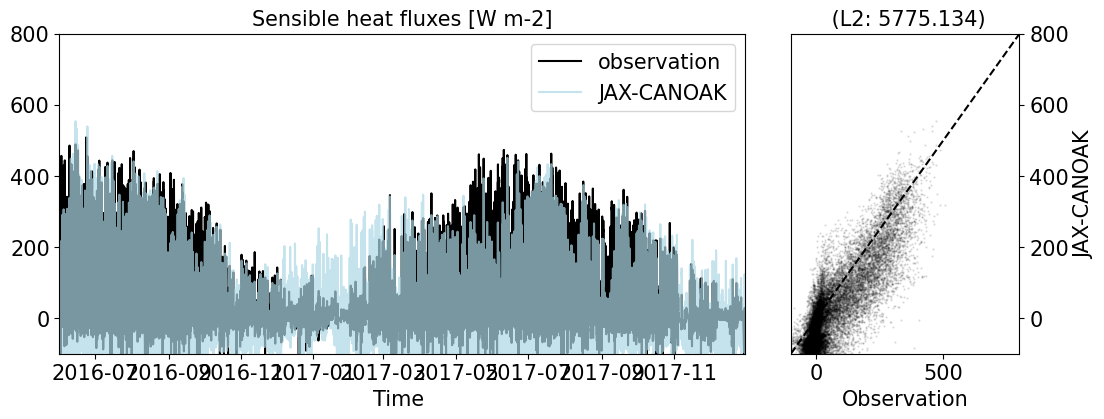

In [19]:
plot_timeseries_obs_1to1(
    obs.H,
    can.H,
    lim=[-100, 800],
    met=met,
    varn="Sensible heat fluxes [W m-2]",
);

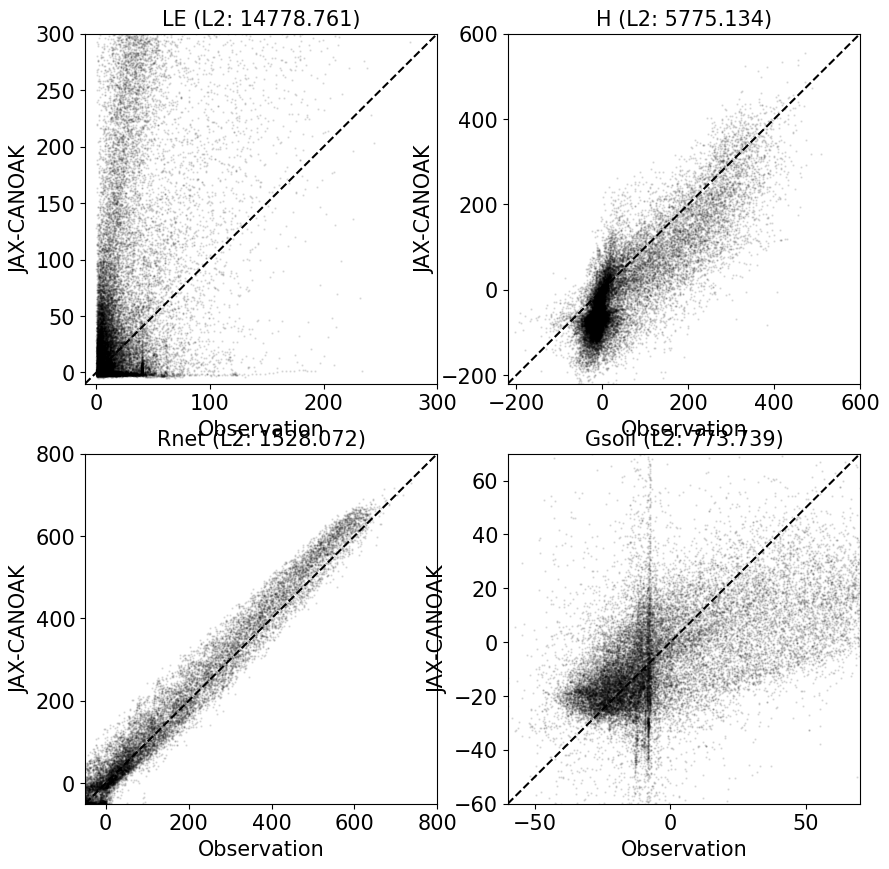

In [20]:
plot_obs_comparison(obs, can);

# Save the models

In [21]:
# Save the configurations
config = {
    "site": site,
    "key": key,
    "f_forcing": f_forcing,
    "f_obs": f_obs,
    "f_forcing_test": f_forcing_test,
    "f_obs_test": f_obs_test,
}
train = {
    "time": timesteps,
    "can.LE": can.LE,
    "sun.gs": sun.gs,
    "shade.gs": shade.gs,
    "sun.Ps": sun.Ps,
    "shade.Ps": shade.Ps,
    "can.H": can.H,
    "can.rnet": can.rnet,
    "can.gsoil": can.gsoil,
    "sun.Tlk": sun.Tsfc,
    "shade.Tlk": shade.Tsfc,
    "sun.Leaf_RH": sun.Leaf_RH,
    "shade.Leaf_RH": shade.Leaf_RH,
    "soil.Tsoil": soil.T_soil,
}
test = {
    "time": timesteps_test,
    "can.LE": can_test.LE,
    "sun.gs": sun_test.gs,
    "shade.gs": shade_test.gs,
    "sun.Ps": sun_test.Ps,
    "shade.Ps": shade_test.Ps,
    "can.H": can_test.H,
    "can.rnet": can_test.rnet,
    "can.gsoil": can_test.gsoil,
    "sun.Tlk": sun_test.Tsfc,
    "shade.Tlk": shade_test.Tsfc,
    "sun.Leaf_RH": sun_test.Leaf_RH,
    "shade.Leaf_RH": shade_test.Leaf_RH,
    "soil.Tsoil": soil_test.T_soil,
}
out = {"train": train, "test": test, "config": config}
pickle.dump(out, open(f"{site}_{key}.pkl", "wb"), pickle.HIGHEST_PROTOCOL)

In [22]:
# Save the model
hyperparams = dict(
    time_zone=time_zone,
    latitude=latitude,
    longitude=longitude,
    stomata=stomata,
    veg_ht=veg_ht,
    leafangle=leafangle,
    n_can_layers=n_can_layers,
    n_atmos_layers=n_atmos_layers,
    meas_ht=meas_ht,
    soil_depth=soil_depth,
    n_hr_per_day=n_hr_per_day,
    n_time=n_time,
    npart=int(1e6),
    niter=niter,
)

save_model(f_model, hyperparams, canveg_eqx_ift)